In [13]:

import numpy as npy # linear algebra
import pandas as pds # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ImgDataGen



In [14]:
# Specify important directories
import os, sys, time, warnings, sklearn
ROOT='/kaggle/input'
# ROOT='data'
TRAIN_PATH=ROOT+'/dataset-fer/final_balanced_dataset/train'
TEST_PATH=ROOT+'/dataset-fer/final_balanced_dataset/test'

train_angry_img_path=TRAIN_PATH +'/angry'

OVERSAMPLED_TRAIN_PATH='fed_oversampled_train'
MODEL_PATH='models'
IMAGE_PATH='images'

# Model Architecture path
def model_arch(model_name):
    # !mkdir -p images
    !mkdir images
    arch=IMAGE_PATH+'/fer-2013_'+model_name+'.png'
    return arch

#  TensorFlow Checkpoint save_weight uses .ckpt extension format
def checkpoint_path(model_name):
    # !mkdir models
    checkpoint_path = MODEL_PATH+"/fedav_best_model-"+model_name+".weights.h5"
    return checkpoint_path
    


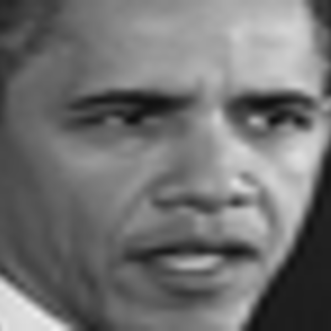

In [15]:
# Load a sample image 
# using open() to open images
image_data = Image.open('/kaggle/input/dataset-fer/final_balanced_dataset/train/angry/aug_2729_im3209.png')
image_data

Image shape: (331, 331, 3)
Image data array: [[[ 40  40  40]
  [ 40  40  40]
  [ 40  40  40]
  ...
  [ 50  50  50]
  [ 47  47  47]
  [ 46  46  46]]

 [[ 40  40  40]
  [ 40  40  40]
  [ 40  40  40]
  ...
  [ 50  50  50]
  [ 47  47  47]
  [ 46  46  46]]

 [[ 40  40  40]
  [ 40  40  40]
  [ 41  41  41]
  ...
  [ 50  50  50]
  [ 47  47  47]
  [ 46  46  46]]

 ...

 [[200 200 200]
  [204 204 204]
  [214 214 214]
  ...
  [ 30  30  30]
  [ 30  30  30]
  [ 30  30  30]]

 [[199 199 199]
  [203 203 203]
  [214 214 214]
  ...
  [ 30  30  30]
  [ 30  30  30]
  [ 30  30  30]]

 [[199 199 199]
  [203 203 203]
  [214 214 214]
  ...
  [ 30  30  30]
  [ 30  30  30]
  [ 30  30  30]]]
Image array shape: (331, 331, 3)


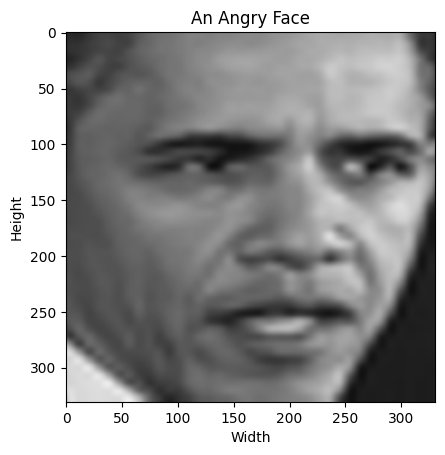

In [16]:
# Get the shape of the image
image=plt.imread('/kaggle/input/dataset-fer/final_balanced_dataset/train/angry/aug_2729_im3209.png')
print(f'Image shape: {image.shape}')

# Convert image data (like jpeg) to numpy using asarray()
image_array = npy.asarray(image_data)
print(f'Image data array: {image_array}')

# Get the shape of the image array
print(f'Image array shape: {image_array.shape}')

# Printing the image 
plt.imshow(image_array)
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('An Angry Face')
plt.show()

In [17]:
# Get the list of folders in the directory as classes
classes=os.listdir(TRAIN_PATH+'/')
classes

['fearful', 'angry', 'neutral', 'sad', 'surprised', 'happy']

In [18]:
def class_sample(type):
    if type.lower() == 'test' or type.lower() == 'train':
        path=''
        if type.lower() == 'train':    
            path= TRAIN_PATH
        else:
            path= TEST_PATH
        
        filepath=path+'/'
        class_count = []
        class_dict ={}
        for folder in os.listdir(filepath) :
              class_count.append(len(os.listdir(filepath+folder)))
              class_dict[folder]=len(os.listdir(filepath+folder))
        class_total = sum(class_count)
        return class_total, class_count, class_dict
    else:
        raise ValueError('Invalid type. Must be "test" or "train".')


def test_train_distribution():
      print("---- Train Set ----")
      avg_train=class_sample('train')[0]/len(class_sample('train')[1])
      print(f'Train class distribution:\n{class_sample("train")[2]}')
      print("Average train class: ",round(avg_train))    
      print('Total train: ', class_sample('train')[0])

      print("\n---- Test Set ----")
      avg_test=class_sample('test')[0]/len(class_sample('test')[1])
      print(f'Test class distribution:\n{class_sample("test")[2]}')
      print("Average test class: ",round(avg_test)) 
      print('Total test: ', class_sample('test')[0])


test_train_distribution()

# test_samples=class_sample('test')[0]
# test_batch_size=sorted([int(test_samples/n) for n in range(1,test_samples+1) if test_samples % n ==0 and test_samples/n<=80],reverse=True)[0]  

---- Train Set ----
Train class distribution:
{'fearful': 5058, 'angry': 5058, 'neutral': 5058, 'sad': 5058, 'surprised': 5058, 'happy': 5058}
Average train class:  5058
Total train:  30348

---- Test Set ----
Test class distribution:
{'fearful': 667, 'angry': 683, 'neutral': 900, 'sad': 770, 'surprised': 565, 'happy': 1265}
Average test class:  808
Total test:  4850


In [19]:
target_size=(48, 48)
# target_size=(224, 224)
batch_size=32

## Train Image Data Generator instance. 
# We will not apply any transformon specific orientations or features and no initial rescale to the image
# We'll only split the image data into train and validation set
trainValidation_data_generator = ImgDataGen(
                                            # rescale=1./225,
                                            rotation_range=10,  # Randomly rotate images by up to 10 degrees
                                            zoom_range=0.2,  # Randomly zoom images by up to 20%
                                            width_shift_range=0.1,  # Randomly shift images horizontally by up to 10% of the image width
                                            height_shift_range=0.1,  # Randomly shift images vertically by up to 10% of the image height
                                            shear_range=0.2,  # Randomly apply shearing transformations
                                            horizontal_flip=True,  # Randomly flip images horizontally
                                            fill_mode='nearest',  # Fill in missing pixels with the nearest value
                                            validation_split=0.2    # set the validation split                                
                                            )


# Test Image Data Generator instance for Test data
test_data_generator = ImgDataGen(
                                # rescale = 1./255,
                                )

# Set a random seed to synchronize the shuffle order across different runs of the generator
# trainValidation_data_generator.set_seed(42)


In [20]:
# Successfully mapped the train-images to their classes from the dataframe. Now let's do the same for the test-images. 
# Here, I will only be rescaling. No other transformations are applies, to preserve originality of the images.

classes = ['angry', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

## Mapping images to their classes.
print('Train Set Generated - ',end=' ') 
train_generator = trainValidation_data_generator.flow_from_directory(
                                                            directory=TRAIN_PATH, 
                                                            # directory=TRAIN_PATH, 
                                                            target_size=target_size,
                                                            batch_size=batch_size,
                                                            class_mode='categorical', 
                                                            color_mode='rgb', 
                                                            classes=classes,
                                                            shuffle=True, 
                                                            subset='training' # set as training data
                                                        )
## Mapping images to their classes.
print('Validation Set Generated - ',end=' ') 
validation_generator = trainValidation_data_generator.flow_from_directory(
                                                            # directory=TRAIN_PATH, 
                                                            directory=TRAIN_PATH, 
                                                            target_size=target_size,
                                                            batch_size=batch_size,
                                                            class_mode='categorical', 
                                                            color_mode='rgb', 
                                                            classes= classes,
                                                            shuffle=False, 
                                                            subset='validation' # set as validation data
                                                        )
test_samples=class_sample('test')[0]
test_batch_size=batch_size
test_steps=int(test_samples/test_batch_size)

## Mapping images to their classes.
print('Test Set Generated - ',end=' ') 
test_generator = test_data_generator.flow_from_directory(
                                        directory=TEST_PATH, 
                                        target_size=target_size,
                                        class_mode='categorical', 
                                        color_mode='rgb', 
                                        classes=classes,
                                        shuffle=False, 
                                        batch_size=test_batch_size
                                        )

## Mapping shuffled images to their classes.
print('Shuffled Test Set Generated - ',end=' ') 
test_generator_shuffled = test_data_generator.flow_from_directory(
                                        TEST_PATH, 
                                        target_size=target_size,
                                        class_mode='categorical', 
                                        color_mode='rgb', 
                                        classes=classes,
                                        shuffle=True, 
                                        batch_size=test_batch_size
                                        )

Train Set Generated -  Found 24282 images belonging to 6 classes.
Validation Set Generated -  Found 6066 images belonging to 6 classes.
Test Set Generated -  Found 4850 images belonging to 6 classes.
Shuffled Test Set Generated -  Found 4850 images belonging to 6 classes.


In [21]:
# From the generator we can get information we will need later
# classes=  # os.listdir(TRAIN_PATH+'/')
class_dictionary = train_generator.class_indices
class_keys = list(train_generator.class_indices.keys())
class_values = list(train_generator.class_indices.values())
class_count = len(class_keys)

print ('test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

train_images, train_labels = next(train_generator)
validation_images, validation_labels = next(validation_generator)
test_images, test_labels = next(test_generator)

print(f'\nThere are 7 classes: {classes}')
print(f'The class dictionary are: {class_dictionary}')
print('Class count: ', class_count)

print('\nX_train shape: ', train_images.shape)
print('y_train shape: ', train_labels.shape)
print('\nX_test shape: ', test_images.shape)
print('y_test shape: ', test_labels.shape)

print('\ntrain_generator sample: ', train_generator.samples)
print('validation_generator sample: ', validation_generator.samples)
print('test_generator sample: ', test_generator.samples)

print('\ntrain_generator sample: ', train_generator.labels)
print('validation_generator sample: ', validation_generator.labels)
print('test_generator sample: ', test_generator.labels)


test batch size:  32   test steps:  151  number of classes :  6

There are 7 classes: ['angry', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
The class dictionary are: {'angry': 0, 'fearful': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprised': 5}
Class count:  6

X_train shape:  (32, 48, 48, 3)
y_train shape:  (32, 6)

X_test shape:  (32, 48, 48, 3)
y_test shape:  (32, 6)

train_generator sample:  24282
validation_generator sample:  6066
test_generator sample:  4850

train_generator sample:  [0 0 0 ... 5 5 5]
validation_generator sample:  [0 0 0 ... 5 5 5]
test_generator sample:  [0 0 0 ... 5 5 5]


In [25]:
from tensorflow import keras
from sklearn import set_config
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ImgDataGen
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.models import Sequential, load_model

from tensorflow.keras import layers, optimizers, metrics, regularizers, models
from tensorflow.keras.optimizers import Adam, Adamax
# from tensorflow.keras.metrics import categorical_crossentropy, sparse_categorical_crossentropy


In [26]:
# define the image shape for the input layer
input_shape=(target_size[0], target_size[1], 3)
batch_size = batch_size
epochs=60
ask_epoch=60


In [27]:
import tensorflow as tf
from tensorflow.keras.models import Model
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(
                                                            include_top=False, 
                                                            weights="imagenet",
                                                            input_shape=input_shape, 
                                                            pooling='max'
                                                            ) 

# Let's make our base_model trainable to get better results
base_model.trainable=True
x=base_model.output

x=BatchNormalization(
                    axis=-1, 
                    momentum=0.99, 
                    epsilon=0.001,
                    name='batch_norm_x' 
                    )(x)
x = Dense(
          256, 
          kernel_regularizer = regularizers.l2(0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006),
          activation='relu',
          name='dense_x'
          )(x)

x=Dropout(
          rate=.4, 
          seed=123,
          name='dropout_x'
          )(x) 
      
output=Dense(
            class_count, 
            activation='softmax',
            name='dense_output'
            )(x)
cnn_model=Model(inputs=base_model.input, outputs=output, name=model_name)
learning_rate=.001 # start with this learning rate
cnn_model.compile(
                  Adamax(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy']
                  )

# View the model summary
cnn_model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EfficientNetB3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 48, 48, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 48, 48, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 48, 48, 3)      │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 48, 48, 3)      │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 49, 49, 3)      │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 24, 24, 40)     │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 24, 24, 40)     │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 24, 24, 40)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 24, 24, 40)     │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 24, 24, 40)     │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 24, 24, 40)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 11,184,693 (42.67 MB)

 Trainable params: 11,094,318 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [30]:
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
class ASK(keras.callbacks.Callback):
    def __init__(self, epochs, ask_epoch):  # Removed `model` from parameters
        super(ASK, self).__init__()
        self.ask_epoch = ask_epoch
        self.subask_epoch = int(ask_epoch / 2)
        self.epochs = epochs
        self.ask = True  # if True query the user on a specified epoch
        
    def on_train_begin(self, logs=None):  # runs at the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch = 1
        if self.ask_epoch >= self.epochs:  # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', self.epochs, ' epochs', flush=True)
            self.ask = False  # do not query the user
        if self.epochs == 1:
            self.ask = False  # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', self.ask_epoch, ' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time = time.time()  # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training     
        tr_duration = time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds'
        print(msg, flush=True)  # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        if self.ask:  # are the conditions right to query the user?
            if epoch + 1 == self.ask_epoch:  # is this epoch the one for querying the user?
                print('\n Enter H to end training or an integer for the number of additional epochs to run then ask again')
                ans = input().strip()
                
                if ans.lower() == 'h' or ans == '0':  # quit training for these conditions
                    print('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True  # halt training
                else:  # user wants to continue training
                    try:
                        self.ask_epoch += int(ans)
                        if self.ask_epoch > self.epochs:
                            print('\nYou earlier specified a maximum epochs of ', self.epochs, '\n, it seems that you want to train for a total of', self.ask_epoch, '\n\n Please confirm your action, please enter "Y", or "N" to end training at ', self.epochs)
                            ans = input().strip()
                            
                            if ans.lower() == 'y':
                                self.epochs = self.ask_epoch
                            else:
                                print('\nYou specified maximum epochs of ', self.epochs, ' cannot train for ', self.ask_epoch, flush=True)
                        else:
                            print('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                    except ValueError:
                        print('Invalid input. Please enter an integer for additional epochs or "H" to halt training.')

# Example Usage:
ask = ASK(epochs, ask_epoch)


In [31]:
# starting the Checkpoint for the model
# checkpoint_dir = os.path.dirname(checkpoint_path)

check_point = tf.keras.callbacks.ModelCheckpoint(
                                          filepath=checkpoint_path(model_name),
                                          save_weights_only=True,
                                          save_best_only=True, 
                                          monitor="val_accuracy",
                                          verbose = 1,
                                        )

reduce_learning = tf.keras.callbacks.ReduceLROnPlateau(
                                            monitor="val_accuracy", 
                                            # factor=0.5, 
                                            patience=2,
                                            verbose=1
                                            )

early_stop = tf.keras.callbacks.EarlyStopping(
                                       monitor="val_accuracy", 
                                       min_delta=0.0005,
                                       patience=11, 
                                       verbose=1,
                                       restore_best_weights=True
                                       )

callbacks = [
            check_point,
            reduce_learning, 
            early_stop, 
            ask
          ]

In [ ]:
import math

steps_per_epoch = math.ceil(train_generator.n / train_generator.batch_size)
validation_steps = math.ceil(validation_generator.n / validation_generator.batch_size)

model_history = cnn_model.fit(
    train_generator,  
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, 
    verbose=1, 
    callbacks=callbacks,  # Ensure this is a valid list of callbacks
    validation_data=validation_generator,
    validation_steps=validation_steps
)


ask_epoch >= epochs, will train for  60  epochs
Training will proceed until epoch 60  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


385/759 ━━━━━━━━━━━━━━━━━━━━ 6:07 983ms/step - accuracy: 0.1789 - loss: 15.4082

In [ ]:
model.save('/kaggle/working/efficient_net_ddd.h5')

In [ ]:
from pylab import rcParams
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
start_epoch = 0
Epoch_count=len(acc)+ start_epoch
Epochs=[]
for i in range (start_epoch ,Epoch_count):
    Epochs.append(i+1)   
index_loss=npy.argmin(val_loss)   #   this is the epoch with the lowest validation loss
val_lowest=val_loss[index_loss]
index_acc=npy.argmax(val_acc)


# summarize history for accuracy using reLU
sns.set()
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')



# summarize history for loss using reLU
plt.subplot(2, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss', fontsize=35)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [ ]:

# 
def ModelPredictionOnTestDataset(test_generator):
#     test_steps= test_generator.n//test_generator.batch_size
    y_pred= []
    y_label=test_generator.labels
    classes=list(train_generator.class_indices.keys())
    class_count=len(classes)
    wrong_predictions=0
    
    # predict on the test set
    preds=cnn_model.predict(test_generator, test_steps, verbose=1) 
    
    total_predictions=len(preds)
    print(f'total prediction: {total_predictions}')
    for i, p in enumerate(preds):
            pred_index=npy.argmax(p)  
            # labels are integer values       
            true_index=test_generator.labels[i]  
            if pred_index != true_index:       
                # a misclassification has occurred                                     
                wrong_predictions=wrong_predictions + 1
            y_pred.append(pred_index)
    acc=( 1-wrong_predictions/total_predictions) * 100
    print(f'\n{wrong_predictions} out of {total_predictions} tested images could not be detected properly.\nAccuracy of {acc:6.2f}\n')
    ypred=npy.array(y_pred)
    ytrue=npy.array(y_label)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(npy.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(npy.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix on Validation Data", fontsize=40)
        plt.show()
    clr = classification_report(y_label, y_pred, target_names=classes, digits= 5) # create classification report
    print("Classification Report on Validation Data:\n-------------------------------------\n", clr)

    return wrong_predictions, total_predictions

wrong_predictions, total_predictions = ModelPredictionOnTestDataset(validation_generator)

In [ ]:
#Code by Hitesh Kumar https://www.kaggle.com/hitzz97/emotion-detection


test_images, test_labels = next(test_generator_shuffled)
preds = cnn_model.predict(test_images)
# print(preds)
idx = npy.argmax(preds, axis = 1)
# test_labels = test_labels.astype(int)
test_labels = npy.argmax(test_labels, axis = 1)
idx = idx.reshape((-1, 1))
test_labels = npy.reshape(test_labels, (len(test_labels), 1))
# print()
print('correct prediction:', npy.sum((test_labels == idx)*1)/test_batch_size)


def compare(idx, train_generator):
    class_dictionary = train_generator.class_indices
    for key, value in class_dictionary.items():
        if value == idx:
             return key

def dif(test_labels, idx, train_generator):    
    class_dictionary = train_generator.class_indices
    test = ''
    id = ''
    for key, value in class_dictionary.items():
        if value == test_labels:
            test = key
        if value == idx:
            id = key
    return test, id



fig = plt.figure(figsize=((20, 30)))

# k = 0
for j in range(len(idx)):
    ax = plt.subplot(7, 5, j+1)
    px = test_images[j]/255
#     k += 1
    ax.imshow(px)
    ax.set_xticks([])
    ax.set_yticks([])
    
#     print(idx[j])
#     print(test_labels[j])
    if test_labels[j] == idx[j]:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(15)
            ax.spines[axis].set_color('green')
        ax.set_title(
                    compare(idx[j], train_generator),
                    color='green', 
                    fontsize=40
                     )

    else:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(15)
            ax.spines[axis].set_color('red')
        ax.set_title(
                    'Pred:'+dif(test_labels[j], idx[j], train_generator)[1]+" | Act:"+ dif(test_labels[j], idx[j], train_generator)[0],
                    color='red', 
                    fontsize=40
                    )
    plt.tight_layout()